In [2]:
from prophet import Prophet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error,root_mean_squared_error
import warnings
warnings.filterwarnings('ignore')


In [3]:
df = pd.read_csv(r'..\..\data\processed\Merch_ML.csv',index_col='Order_ID')
df.head()

,Order_Date,Buyer_Age,Sales_Price,Shipping_Charges,Sales_per_Unit,Quantity,Total_Sales,Rating,Product_ID,Order_Location,International_Shipping,Buyer_Gender,Product_Category_Clothing,Product_Category_Ornaments,Product_Category_Other
Order_ID,,,,,,,,,,,,,,,
189440,2024-07-21,30,100,0,100,1,100,4,0,15,0,1,1.0,0.0,0.0
187385,2024-07-20,32,100,0,100,1,100,3,0,6,0,1,1.0,0.0,0.0
181844,2024-07-21,26,9,40,49,1,49,2,1,1,1,0,0.0,0.0,1.0
197934,2024-08-19,28,9,0,9,2,18,3,1,18,0,1,0.0,0.0,1.0
122470,2024-01-06,19,10,0,10,3,30,5,2,11,0,0,0.0,0.0,1.0


In [4]:
df['Order_Date'] = pd.to_datetime(df['Order_Date'])

In [5]:
nov_24 = df[(df['Order_Date'].dt.month == 11) & (df['Order_Date'].dt.year == 2024)]

In [6]:
df.drop(df[(df['Order_Date'].dt.month == 11) & (df['Order_Date'].dt.year == 2024)].index,axis=0,inplace=True)

In [7]:
df['Total_Sales'] = np.log1p(df['Total_Sales'])

In [8]:
from prophet import Prophet
import numpy as np
from sklearn.metrics import mean_absolute_error

mae_scores = {}
mape_scores = {}

for product in df['Product_ID'].unique():
    df_product = df[df['Product_ID'] == product][['Order_Date', 'Total_Sales']].rename(columns={'Order_Date': 'ds', 'Total_Sales': 'y'})
    
    # 🔹 Aplicar log1p para mayor estabilidad
    df_product['y'] = np.log1p(df_product['y'])

    # Crear y entrenar Prophet con estacionalidad ajustada
    model = Prophet(
        changepoint_prior_scale=0.1,
        yearly_seasonality=True,
        seasonality_prior_scale=20
    )
    model.add_seasonality(name='monthly', period=30.5, fourier_order=10)  # Agregar estacionalidad manual
    model.fit(df_product)

    # Hacer predicción en las mismas fechas reales
    future = df_product[['ds']]
    forecast = model.predict(future)

    # Obtener valores reales y predicciones
    y_true = df_product['y'].values
    y_pred = forecast['yhat'].values

    # 🔹 Evaluar en escala log antes de desescalar
    mae_log = mean_absolute_error(y_true, y_pred)
    mape_log = np.mean(np.abs((y_true - y_pred) / np.maximum(y_true, 1))) * 100

    print(f'Producto {product} - MAE log: {mae_log:.2f}, MAPE log: {mape_log:.2f}%')

    # 🔹 Deshacer log1p
    y_true_original = np.expm1(y_true)
    y_pred_original = np.expm1(y_pred)

    # Calcular errores en escala original
    mae = mean_absolute_error(y_true_original, y_pred_original)
    mae_scores[product] = mae

    mape = np.mean(np.abs((y_true_original - y_pred_original) / np.maximum(y_true_original, 1))) * 100
    mape_scores[product] = mape

    print(f'Producto {product} - MAE real: {mae:.2f}, MAPE real: {mape:.2f}%')

print("\nResumen de errores:")
for product in mae_scores.keys():
    print(f'Producto {product} → MAE: {mae_scores[product]:.2f}, MAPE: {mape_scores[product]:.2f}%')



15:57:08 - cmdstanpy - INFO - Chain [1] start processing
15:57:08 - cmdstanpy - INFO - Chain [1] done processing
15:57:08 - cmdstanpy - INFO - Chain [1] start processing


Producto 0 - MAE log: 0.08, MAPE log: 4.37%
Producto 0 - MAE real: 0.50, MAPE real: 9.42%


15:57:09 - cmdstanpy - INFO - Chain [1] done processing
15:57:09 - cmdstanpy - INFO - Chain [1] start processing


Producto 1 - MAE log: 0.19, MAPE log: 13.91%
Producto 1 - MAE real: 0.82, MAPE real: 25.95%


15:57:09 - cmdstanpy - INFO - Chain [1] done processing
15:57:09 - cmdstanpy - INFO - Chain [1] start processing


Producto 2 - MAE log: 0.19, MAPE log: 13.38%
Producto 2 - MAE real: 0.83, MAPE real: 25.32%


15:57:09 - cmdstanpy - INFO - Chain [1] done processing
15:57:09 - cmdstanpy - INFO - Chain [1] start processing


Producto 3 - MAE log: 0.07, MAPE log: 3.65%
Producto 3 - MAE real: 0.42, MAPE real: 7.92%


15:57:10 - cmdstanpy - INFO - Chain [1] done processing


Producto 4 - MAE log: 0.11, MAPE log: 6.71%
Producto 4 - MAE real: 0.57, MAPE real: 13.60%


15:57:10 - cmdstanpy - INFO - Chain [1] start processing
15:57:10 - cmdstanpy - INFO - Chain [1] done processing
15:57:10 - cmdstanpy - INFO - Chain [1] start processing


Producto 5 - MAE log: 0.08, MAPE log: 4.64%
Producto 5 - MAE real: 0.47, MAPE real: 9.74%


15:57:10 - cmdstanpy - INFO - Chain [1] done processing
15:57:11 - cmdstanpy - INFO - Chain [1] start processing


Producto 6 - MAE log: 0.07, MAPE log: 4.00%
Producto 6 - MAE real: 0.48, MAPE real: 8.73%


15:57:11 - cmdstanpy - INFO - Chain [1] done processing


Producto 7 - MAE log: 0.07, MAPE log: 4.10%
Producto 7 - MAE real: 0.46, MAPE real: 8.82%


15:57:11 - cmdstanpy - INFO - Chain [1] start processing
15:57:11 - cmdstanpy - INFO - Chain [1] done processing
15:57:12 - cmdstanpy - INFO - Chain [1] start processing


Producto 8 - MAE log: 0.16, MAPE log: 10.48%
Producto 8 - MAE real: 0.72, MAPE real: 20.25%


15:57:12 - cmdstanpy - INFO - Chain [1] done processing
15:57:12 - cmdstanpy - INFO - Chain [1] start processing


Producto 9 - MAE log: 0.10, MAPE log: 5.65%
Producto 9 - MAE real: 0.52, MAPE real: 11.62%


15:57:12 - cmdstanpy - INFO - Chain [1] done processing
15:57:12 - cmdstanpy - INFO - Chain [1] start processing


Producto 10 - MAE log: 0.10, MAPE log: 5.77%
Producto 10 - MAE real: 0.54, MAPE real: 12.00%


15:57:12 - cmdstanpy - INFO - Chain [1] done processing
15:57:12 - cmdstanpy - INFO - Chain [1] start processing


Producto 11 - MAE log: 0.14, MAPE log: 8.92%
Producto 11 - MAE real: 0.67, MAPE real: 17.55%


15:57:12 - cmdstanpy - INFO - Chain [1] done processing


Producto 12 - MAE log: 0.15, MAPE log: 9.57%
Producto 12 - MAE real: 0.74, MAPE real: 19.02%

Resumen de errores:
Producto 0 → MAE: 0.50, MAPE: 9.42%
Producto 1 → MAE: 0.82, MAPE: 25.95%
Producto 2 → MAE: 0.83, MAPE: 25.32%
Producto 3 → MAE: 0.42, MAPE: 7.92%
Producto 4 → MAE: 0.57, MAPE: 13.60%
Producto 5 → MAE: 0.47, MAPE: 9.74%
Producto 6 → MAE: 0.48, MAPE: 8.73%
Producto 7 → MAE: 0.46, MAPE: 8.82%
Producto 8 → MAE: 0.72, MAPE: 20.25%
Producto 9 → MAE: 0.52, MAPE: 11.62%
Producto 10 → MAE: 0.54, MAPE: 12.00%
Producto 11 → MAE: 0.67, MAPE: 17.55%
Producto 12 → MAE: 0.74, MAPE: 19.02%


In [9]:
from statsmodels.tsa.stattools import adfuller

# Prueba de Dickey-Fuller
adf_test = adfuller(df_product['y'])
print(f'ADF Statistic: {adf_test[0]}')
print(f'p-value: {adf_test[1]}')

# Interpretación
if adf_test[1] < 0.05:
    print("La serie es estacionaria (rechazamos H0)")
else:
    print("La serie NO es estacionaria (no podemos rechazar H0)")


ADF Statistic: -10.117611565476572
p-value: 9.631398278016664e-18
La serie es estacionaria (rechazamos H0)


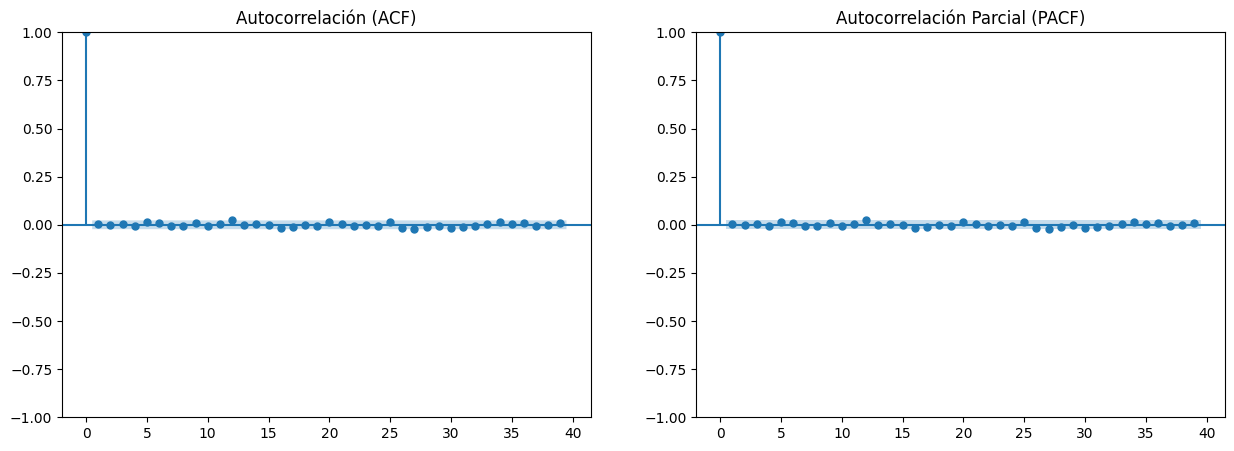

In [10]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Graficar ACF y PACF de la serie diferenciada
fig, axes = plt.subplots(1, 2, figsize=(15,5))

plot_acf(df['Total_Sales'], ax=axes[0])  # ACF
axes[0].set_title("Autocorrelación (ACF)")

plot_pacf(df['Total_Sales'], ax=axes[1])  # PACF
axes[1].set_title("Autocorrelación Parcial (PACF)")

plt.show()


In [11]:
from statsmodels.tsa.arima.model import ARIMA

productos_altos_errores = [1, 2, 8, 11, 12]  # Productos con MAPE > 20%

for product in productos_altos_errores:
    df_product = df[df['Product_ID'] == product].set_index('Order_Date')['Total_Sales']
    
    model = ARIMA(df_product, order=(1,0,1))  # Ajustar según ACF/PACF
    model_fit = model.fit()

    forecast = model_fit.forecast(steps=3)
    print(f'Producto {product} - Predicciones ARIMA:', forecast)


c:\Users\Abdon.RAMIREZ-BRICEN\AppData\Local\pypoetry\Cache\virtualenvs\proyecto_ml-ofZbHP6o-py3.12\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Abdon.RAMIREZ-BRICEN\AppData\Local\pypoetry\Cache\virtualenvs\proyecto_ml-ofZbHP6o-py3.12\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Abdon.RAMIREZ-BRICEN\AppData\Local\pypoetry\Cache\virtualenvs\proyecto_ml-ofZbHP6o-py3.12\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Abdon.RAMIREZ-BRICEN\AppData\Loca

Producto 1 - Predicciones ARIMA: 721    3.171346
722    3.163832
723    3.158525
Name: predicted_mean, dtype: float64
Producto 2 - Predicciones ARIMA: 564    3.314620
565    3.314458
566    3.314609
Name: predicted_mean, dtype: float64
Producto 8 - Predicciones ARIMA: 935    3.528932
936    3.537824
937    3.541319
Name: predicted_mean, dtype: float64
Producto 11 - Predicciones ARIMA: 439    3.696208
440    3.757591
441    3.756850
Name: predicted_mean, dtype: float64
Producto 12 - Predicciones ARIMA: 133    3.799868
134    3.818338
135    3.828259
Name: predicted_mean, dtype: float64


c:\Users\Abdon.RAMIREZ-BRICEN\AppData\Local\pypoetry\Cache\virtualenvs\proyecto_ml-ofZbHP6o-py3.12\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Abdon.RAMIREZ-BRICEN\AppData\Local\pypoetry\Cache\virtualenvs\proyecto_ml-ofZbHP6o-py3.12\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Abdon.RAMIREZ-BRICEN\AppData\Local\pypoetry\Cache\virtualenvs\proyecto_ml-ofZbHP6o-py3.12\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Abdon.RAMIREZ-BRICEN\AppData\Local\pypoetry\Cache

In [12]:
df['Order_Date'] = pd.to_datetime(df['Order_Date'])
df['year'] = df['Order_Date'].dt.year
df['month'] = df['Order_Date'].dt.month

# Crear una tabla con ventas agregadas por producto y mes
df_monthly = df.groupby(['Product_ID', 'year', 'month'])['Total_Sales'].sum().reset_index()

# Crear variables de retraso (lag) para ventas pasadas
df_monthly['ventas_t-1'] = df_monthly.groupby('Product_ID')['Total_Sales'].shift(1)
df_monthly['ventas_t-2'] = df_monthly.groupby('Product_ID')['Total_Sales'].shift(2)
df_monthly['ventas_t-3'] = df_monthly.groupby('Product_ID')['Total_Sales'].shift(3)

# Eliminar filas con NaN (los primeros meses no tienen datos previos suficientes)
df_monthly = df_monthly.dropna()

# Definir variables de entrada (X) y salida (y)
X = df_monthly[['Product_ID', 'ventas_t-1', 'ventas_t-2', 'ventas_t-3']]
y = df_monthly['Total_Sales']

In [13]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,root_mean_squared_error

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
model = XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=6)
model.fit(X_train, y_train)

# Predicciones y evaluación
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test,y_pred)
print(f'MAE XGBoost: {mae:.2f}')
print(f'RMSE XGBoost: {rmse:.2f}')

MAE XGBoost: 28.92
RMSE XGBoost: 40.48


In [16]:
future_predictions = []

for product in df['Product_ID'].unique():
    last_sales = df_monthly[df_monthly['Product_ID'] == product].iloc[-3:]['Total_Sales'].values.tolist()

    for i in range(3):  # Predecir los próximos 3 meses
        X_new = np.array([[product, last_sales[-1], last_sales[-2], last_sales[-3]]])  # Crear entrada
        y_pred = model.predict(X_new)[0]  # Predecir con XGBoost
        future_predictions.append([product, y_pred])
        
        # Actualizar ventas pasadas para la siguiente predicción
        last_sales.append(y_pred)
        last_sales.pop(0)  # Elimina el dato más viejo

# Convertir predicciones a DataFrame
future_df = pd.DataFrame(future_predictions, columns=['Product_ID', 'Predicted_Sales'])
future_df

,Product_ID,Predicted_Sales
0,0,316.966522
1,0,341.846466
2,0,321.316498
3,1,198.275635
4,1,135.319397
5,1,173.086823
6,2,163.643463
7,2,167.701233
8,2,167.243271
9,3,140.955704


In [17]:
df_monthly['Product_ID'].value_counts()


Product_ID
0     9
1     9
2     9
3     9
4     9
5     9
6     9
7     9
8     9
9     9
10    9
11    9
12    9
Name: count, dtype: int64

In [18]:
print("Últimos valores de ventas por producto usados como input:")
for product in df['Product_ID'].unique():
    last_sales = df_monthly[df_monthly['Product_ID'] == product].iloc[-3:]['Total_Sales'].values.tolist()
    print(f'Producto {product}: {last_sales}')


Últimos valores de ventas por producto usados como input:
Producto 0: [240.14710178706645, 284.017488013558, 289.1920012347081]
Producto 1: [169.93479324386817, 229.27942753609673, 154.72029146615614]
Producto 2: [153.89925828584316, 134.74895053226098, 155.724290862947]
Producto 3: [199.72701171206876, 145.05983157976567, 148.8318202739847]
Producto 4: [110.16041740222161, 95.50304187715597, 94.19307736299955]
Producto 5: [534.8057025282859, 483.98945067517093, 573.1874640943756]
Producto 6: [97.05997420185054, 215.18195642548082, 157.17846404928417]
Producto 7: [339.94180857284323, 320.7509598059459, 367.6691996136327]
Producto 8: [223.6877066781119, 295.1056668708896, 215.49668147616524]
Producto 9: [89.71551544735513, 120.69670346339785, 98.56296713292217]
Producto 10: [76.30480261207889, 97.97000364236638, 75.24778615417998]
Producto 11: [156.160427355035, 118.6556784704453, 146.72509070634362]
Producto 12: [45.03659306070968, 63.89250232535376, 39.55299751741688]
